In [1]:
%run task2a.ipynb
import numpy as np
import utils
import matplotlib.pyplot as plt
#from task2a import cross_entropy_loss, SoftmaxModel, one_hot_encode, pre_process_images
from trainer import BaseTrainer
np.random.seed(0)

Train shape: X: (20000, 784), Y: (20000, 1)
Validation shape: X: (10000, 784), Y: (10000, 1)
Standard deviation: 49.37799682313607
Mean value: 33.55274553571429
Initializing weight to shape: (785, 64)
Initializing weight to shape: (64, 10)


In [2]:
def calculate_accuracy(X: np.ndarray, targets: np.ndarray, model: SoftmaxModel) -> float:
    """
    Args:
        X: images of shape [batch size, 785]
        targets: labels/targets of each image of shape: [batch size, 10]
        model: model of class SoftmaxModel
    Returns:
        Accuracy (float)
    """
    # TODO: Implement this function (copy from last assignment)
    y_hat = model.forward(X)
    accuracy_count = np.count_nonzero(np.argmax(y_hat, axis=1) == np.argmax(targets, axis=1))
    accuracy = accuracy_count/X.shape[0]
    return accuracy

In [3]:
class SoftmaxTrainer(BaseTrainer):

    def __init__(
            self,
            momentum_gamma: float,
            use_momentum: bool,
            *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.momentum_gamma = momentum_gamma
        self.use_momentum = use_momentum
        # Init a history of previous gradients to use for implementing momentum
        self.previous_grads = [np.zeros_like(w) for w in self.model.ws]
        

    def train_step(self, X_batch: np.ndarray, Y_batch: np.ndarray):
        """
        Perform forward, backward and gradient descent step here.
        The function is called once for every batch (see trainer.py) to perform the train step.
        The function returns the mean loss value which is then automatically logged in our variable self.train_history.

        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        # TODO: Implement this function (task 2c)

        loss = 0
        logits = self.model.forward(X_batch)
        self.model.backward(X_batch, logits, Y_batch)
        for i in range(len(self.model.ws)):
            if self.use_momentum:
                deltaW = self.model.grads[i] + self.momentum_gamma*self.previous_grads[i]
                self.model.ws[i] -= self.learning_rate*deltaW
                self.previous_grads[i] = deltaW
            else:
                self.model.ws[i] -= self.learning_rate*self.model.grads[i]
        loss = cross_entropy_loss(Y_batch, logits) 
        return loss

    def validation_step(self):
        """
        Perform a validation step to evaluate the model at the current step for the validation set.
        Also calculates the current accuracy of the model on the train set.
        Returns:
            loss (float): cross entropy loss over the whole dataset
            accuracy_ (float): accuracy over the whole dataset
        Returns:
            loss value (float) on batch
            accuracy_train (float): Accuracy on train dataset
            accuracy_val (float): Accuracy on the validation dataset
        """
        # NO NEED TO CHANGE THIS FUNCTION
        logits = self.model.forward(self.X_val)
        loss = cross_entropy_loss(self.Y_val, logits)

        accuracy_train = calculate_accuracy(
            self.X_train, self.Y_train, self.model)
        accuracy_val = calculate_accuracy(
            self.X_val, self.Y_val, self.model)
        return loss, accuracy_train, accuracy_val


Train shape: X: (20000, 784), Y: (20000, 1)
Validation shape: X: (10000, 784), Y: (10000, 1)
Standard deviation: 49.37799682313607
Mean value: 33.55274553571429
Standard deviation: 49.06676795408154
Mean value: 33.791224489795916
Initializing weight to shape: (785, 64)
Initializing weight to shape: (64, 64)
Initializing weight to shape: (64, 10)
Early stop at  17 epochs
Final Train Cross Entropy Loss: 0.02054591745064664
Final Validation Cross Entropy Loss: 0.20468056570243703
Train accuracy: 0.99345
Validation accuracy: 0.9517


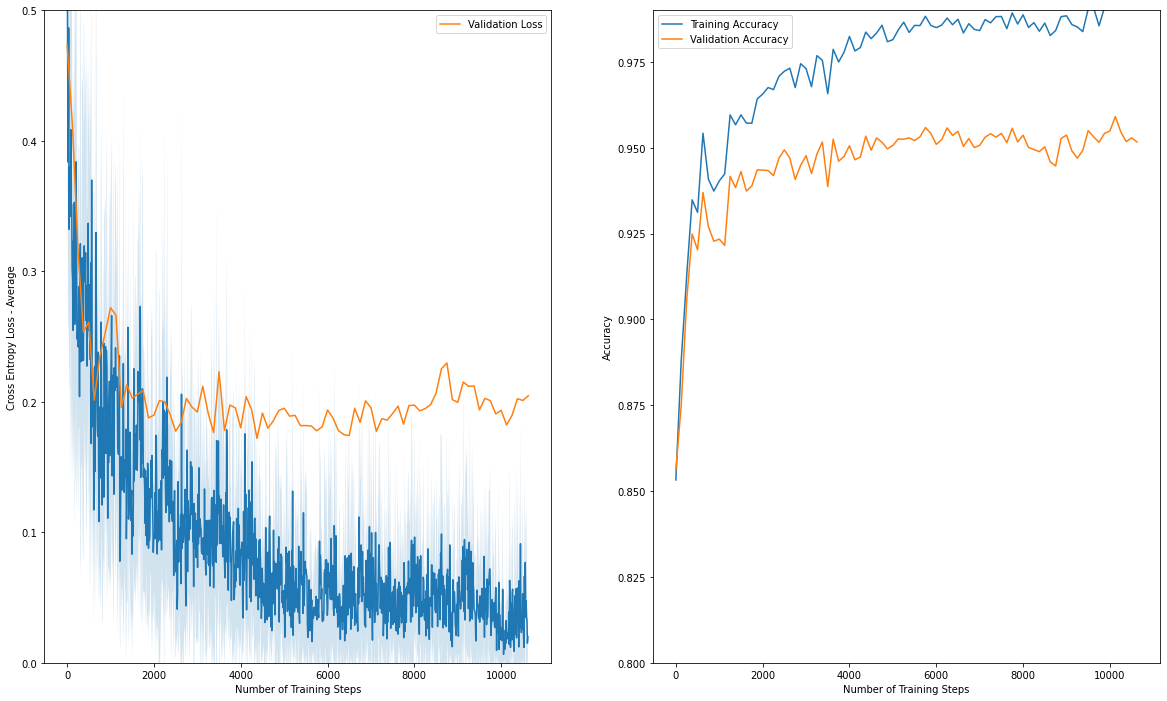

In [4]:

if __name__ == "__main__":
    # hyperparameters DO NOT CHANGE IF NOT SPECIFIED IN ASSIGNMENT TEXT
    num_epochs = 50
    #learning_rate = .1  #For task 2
    learning_rate = .02 #For task 3 and 4
    batch_size = 32
    #neurons_per_layer = [128, 10]
    neurons_per_layer = [64, 64, 10]
    momentum_gamma = .9  # Task 3 hyperparameter
    shuffle_data = True

    # Settings for task 3. Keep all to false for task 2.
    use_improved_sigmoid = True
    use_improved_weight_init = True
    use_momentum = True

    # Load dataset
    X_train, Y_train, X_val, Y_val = utils.load_full_mnist()
    X_train = pre_process_images(X_train)
    X_val = pre_process_images(X_val)
    Y_train = one_hot_encode(Y_train, 10)
    Y_val = one_hot_encode(Y_val, 10)
    # Hyperparameters

    model = SoftmaxModel(
        neurons_per_layer,
        use_improved_sigmoid,
        use_improved_weight_init)
    trainer = SoftmaxTrainer(
        momentum_gamma, use_momentum,
        model, learning_rate, batch_size, shuffle_data,
        X_train, Y_train, X_val, Y_val,
    )
    train_history, val_history = trainer.train(num_epochs)

    print("Final Train Cross Entropy Loss:",
          cross_entropy_loss(Y_train, model.forward(X_train)))
    print("Final Validation Cross Entropy Loss:",
          cross_entropy_loss(Y_val, model.forward(X_val)))
    print("Train accuracy:", calculate_accuracy(X_train, Y_train, model))
    print("Validation accuracy:", calculate_accuracy(X_val, Y_val, model))

    # Plot loss for first model (task 2c)
    plt.figure(figsize=(20, 12))
    plt.subplot(1, 2, 1)
    plt.ylim([0., .5])
    utils.plot_loss(train_history["loss"],
                    "Training Loss", npoints_to_average=10)
    utils.plot_loss(val_history["loss"], "Validation Loss")
    plt.legend()
    plt.xlabel("Number of Training Steps")
    plt.ylabel("Cross Entropy Loss - Average")
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.ylim([0.80, .99])
    utils.plot_loss(train_history["accuracy"], "Training Accuracy")
    utils.plot_loss(val_history["accuracy"], "Validation Accuracy")
    plt.xlabel("Number of Training Steps")
    plt.ylabel("Accuracy")
    plt.legend()
    #plt.savefig("task2c_train_loss.png")
    #plt.savefig("task4d.png")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc7fa119-6ed4-4d50-aa34-54bc46270896' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>